## Frank-Wolfe Algorithms

The Frank-Wolfe algorithm, also known as the Conditional Gradient method, is an iterative first-order optimization algorithm designed to solve constrained optimization problems.

## Max-clique problem
The maximum clique problem aims to identify the largest clique C, or the largest subset of the given graph G such that every two distinct vertices in C are adjacent.

### Preparation

This code provides utility functions for downloading a graph file from a given URL where instances were retrived from, saving it locally, and then loading it as an adjacency matrix.

In [ ]:
import os
import time
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import linprog
def download_and_save(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def load_dimacs_graph(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    edges = []
    for line in lines:
        if line.startswith('e'):
            _, u, v = line.split()
            edges.append((int(u)-1, int(v)-1))
    G = nx.Graph()
    G.add_edges_from(edges)
    A = nx.adjacency_matrix(G).toarray()
    return A


### Linear Minimization Oracle

The Linear Minimization Oracle (LMO) function is used to solve the subproblem of finding the search direction that minimizes the linear approximation of the objective function over the feasible region.



$$
\text{LMO}_{\mathcal{c}}(\mathbf{g}) \in \arg \min_{\mathbf{z} \in \mathcal{c}} \mathbf{g}^T \mathbf{z}
$$

where:
- *g* is the gradient of the objective function at the current iteration.
- *C* is the feasible set.

The LMO finds the point z within the feasible set C that minimizes the dot product with the gradient g. This direction is then used to update the solution in the Frank-Wolfe algorithm.






In [ ]:
def lmo(grad):
    # Return an array of zeros with the same shape and type as gradient
    e = np.zeros_like(grad)
    #finds the index of the minimum value in the grad array and update vector e
    #to return basis vector e that minimizes dot product with the gradient
    e[np.argmin(grad)] = 1
    return e

###Objective function definition
This code defines a function f which represents the objective function of an optimization problem. The function takes three arguments: *A, x,* and *alpha*, and returns a scalar value computed based on these inputs.

The function computes the following value:

$$f(x) = -x^T A x - \frac{1}{2} \|x\|^2$$


The second term represents a L2 regularization term.



In [ ]:
def f(A, x, alpha):
    return -x.T @ A @ x - 0.5 * np.linalg.norm(x)**2

### Gradient of objective function

The `grad_f` function computes the gradient of an objective function, which includes a quadratic term and L2 regularization term.
The function computes the gradient as:
$$
\nabla f(\mathbf{x}) = -2A\mathbf{x} - 2\alpha\mathbf{x}
$$

The α is set to 0.5 as a default value.


In [ ]:
def grad_f(A, x, alpha):
    return -2 * A @ x - 2 * alpha * x

### Strategies to determine the step size for FW algorithms
In our implementation of the optimization algorithms, we will utilize different strategies for determining the step size to enhance the efficiency and convergence of the algorithms.
##### **Standard Frank-Wolfe (FW) Algorithm**:
- Diminishing Step Size

- Exact Line Search

- Armijo Rule


##### **Away-steps Frank-Wolfe (AFW) Algorithm**:
- Exact Line Search

- Armijo Rule

##### **Pairwise Frank-Wolfe (PFW) Algorithm**:
- Exact Line Search

- Armijo Rule

In [ ]:
from scipy.optimize import minimize_scalar
def exact_line_search(f, x, d, gamma_max=1.0):
    phi = lambda gamma: f(x + gamma * d)

    # Perform the line search within the interval [0, gamma_max]
    result = minimize_scalar(phi, bounds=(0, gamma_max), method='bounded')

    # Return the optimal step size gamma
    return result.x

def armijo(f, x, d, grad, alpha=0.1, beta=0.7, gamma_max = 1.0):
    gamma = gamma_max
    while f(x + gamma * d) > f(x) + alpha * gamma * np.dot(grad, d):
        gamma *= beta
    return gamma

#### Standard Frank Wolfe algorithm with diminishing step size

The frank_wolfe function implements the Frank-Wolfe algorithm, which is an iterative optimization method for constrained convex problems. The algorithm alternates between computing the gradient, solving a linear minimization problem to find the search direction, and updating the current point using a diminishing step size. The convergence of the algorithm is monitored by the value of the objective function at each iteration and the norm of the search direction.

By using this approach, the Frank-Wolfe algorithm efficiently navigates the feasible region
𝐶
 to find the optimal solution to the given optimization problem.

In [ ]:
def frank_wolfe_dimin(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    convergence = []
    time_list = []
    start_time = time.time()
    for k in range(max_iter):
        # compute the gradient and lmo
        grad = grad_f(A, x, alpha)
        s = lmo(grad)

        # set the direction and update x
        d_fw = s - x
        gamma = 2 / (k + 2) # applying diminishing step size method
        x = x + gamma * d_fw

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append((iter_time - start_time))

        # compute duality gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break
    return x, convergence, time_list


#### Standard Frank Wolfe algorithm with Armijo rule step size

In [ ]:
def frank_wolfe_armijo(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    convergence = []
    time_list = []
    start_time = time.time()
    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # use Armijo rule to find the optimal gamma and update x
        gamma = armijo(lambda z: f(A, z, alpha), x, d_fw, grad)
        x = x + gamma * d_fw

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append((iter_time - start_time))

        # compute duality gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break
    return x, convergence, time_list

#### Standard Frank Wolfe algorithm with exact line search

In [ ]:
def frank_wolfe_els(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    convergence = []
    time_list = []
    start_time = time.time()
    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # use exact line search to find the optimal gamma and update x
        gamma = exact_line_search(lambda z: f(A, z, alpha), x, d_fw)
        x = x + gamma * d_fw

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append((iter_time - start_time))

        # compute duality gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break
    return x, convergence, time_list

#### Pairwise Frank Wolfe with Armijo rule step size
The PFW algorithm introduces a more efficient way of updating the solution by considering pairwise exchanges within the active set, enhancing convergence rates. Instead of a direct move towards *s* (as in standard Frank-Wolfe), PFW considers moving in the direction *d_pfw = s - v*. This allows for a more nuanced adjustment by reducing the weight of *v* while increasing the weight of *s*.





In [ ]:
def array_equal(a, b):
    return np.all(a == b)

def pairwise_frank_wolfe_armijo(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    active_set = [x.copy()]
    weights = [1.0]
    convergence = []
    time_list = []
    start_time = time.time()

    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # determine away direction
        v_idx = np.argmax([np.dot(grad, y) for y in active_set])
        v = active_set[v_idx]
        d_a = x - v

        # compute FW gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break

        # compute pairwise FW direction
        d_pfw = s - v
        gamma_max = weights[v_idx]

        # use Armijo rule to find the optimal gamma and update x
        gamma = armijo(lambda z: f(A, z, alpha), x, d_pfw, grad, gamma_max = gamma_max)
        x = x + gamma * d_pfw

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append(iter_time - start_time)

        # update weights for s and v
        if not any(np.array_equal(s, a) for a in active_set):
          active_set.append(s.copy())
          weights.append(0)

        s_idx = next(i for i, a in enumerate(active_set) if np.array_equal(s, a))
        weights[s_idx] += gamma
        weights[v_idx] -= gamma

        if weights[v_idx] <= 0:
            active_set.pop(v_idx)
            weights.pop(v_idx)

    return x, convergence, time_list


#### Pairwise Frank Wolfe with exact line search


In [ ]:
def pairwise_frank_wolfe_els(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    active_set = [x.copy()]
    weights = [1.0]
    convergence = []
    time_list = []
    start_time = time.time()

    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # determine away direction
        v_idx = np.argmax([np.dot(grad, y) for y in active_set])
        v = active_set[v_idx]
        d_a = x - v

        # compute FW gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break

        # compute pairwise FW direction
        d_pfw = s - v
        gamma_max = weights[v_idx]

        # ensure gamma_max is not too small
        if gamma_max < 1e-5:
            gamma_max = 1e-5

        gamma = exact_line_search(lambda z: f(A, z, alpha), x, d_pfw, gamma_max=gamma_max)

        # update x
        x = x + gamma * d_pfw

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append(iter_time - start_time)

        # update weights for s and v
        if not any(np.array_equal(s, a) for a in active_set):
          active_set.append(s.copy())
          weights.append(0)

        s_idx = next(i for i, a in enumerate(active_set) if np.array_equal(s, a))
        weights[s_idx] += gamma
        weights[v_idx] -= gamma

        if weights[v_idx] <= 0:
            active_set.pop(v_idx)
            weights.pop(v_idx)

    return x, convergence, time_list

#### Away Step Frank-Wolfe with Armijo rule step size

AFW introduces an "away step" mechanism that allows the algorithm to efficiently handle the active set of constraints, making it suitable for problems where the solution lies at the boundary of the feasible region. AFW identifies a point *v* from the current active set that maximizes the inner product with the gradient. This defines the away direction *d_a = x - v*.


In [ ]:
def away_step_frank_wolfe_armijo(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    active_set = [x.copy()]
    weights = [1.0]
    convergence = []
    time_list = []
    start_time = time.time()

    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # determine away direction
        v_idx = np.argmax([np.dot(grad, y) for y in active_set])
        v = active_set[v_idx]
        d_a = x - v

        # compute FW gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break

        # decide on direction d
        if np.dot(grad, d_fw) <= np.dot(grad, d_a):
            d = d_fw
            gamma_max = 1.0
        else:
            d = d_a
            alpha_vt = weights[v_idx]
            gamma_max = alpha_vt / (1 - alpha_vt)

        # perform backtracking line search and update x
        gamma = armijo(lambda z: f(A, z, alpha), x, d, grad, gamma_max = gamma_max)
        x = x + gamma * d

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append(iter_time - start_time)

        # update active set and weights
        if np.array_equal(d, d_fw):
            if gamma < 1:
                if not any(np.array_equal(s, a) for a in active_set):
                    active_set.append(s.copy())
                    weights.append(0)

            s_idx = next(i for i, a in enumerate(active_set) if np.array_equal(s, a))
            weights[s_idx] = (1-gamma)*weights[s_idx] + gamma
            for idx in range(len(weights)):
                if idx != s_idx:
                    weights[idx] *= (1 - gamma)
        else:
            if gamma == gamma_max:
                weights[v_idx] = 0

            weights[v_idx] = (1 + gamma) * weights[v_idx] - gamma
            for idx in range(len(weights)):
                if idx != v_idx:
                    weights[idx] *= (1 + gamma)

            if weights[v_idx] <= 0:
                active_set.pop(v_idx)
                weights.pop(v_idx)
    return x, convergence, time_list

#### Away Step Frank-Wolfe with exact line search

In [ ]:
def away_step_frank_wolfe_els(A, x0, max_iter=100, tol=1e-6, alpha=0.5):
    x = x0
    active_set = [x.copy()]
    weights = [0]
    convergence = []
    time_list = []
    start_time = time.time()
    backtrack_checker = 0

    for k in range(max_iter):
        # compute the gradient and lmo and determine the FW direction
        grad = grad_f(A, x, alpha)
        s = lmo(grad)
        d_fw = s - x

        # determine away direction
        v_idx = np.argmax([np.dot(grad, y) for y in active_set])
        v = active_set[v_idx]
        d_a = x - v

        # compute FW gap and check stopping condition
        fw_gap = -np.dot(grad, d_fw)
        if fw_gap <= tol:
            break

        # decide on direction d
        if np.dot(grad, d_fw) <= np.dot(grad, d_a):
            d = d_fw
            gamma_max = 1.0
        else:
            d = d_a
            alpha_vt = weights[v_idx]
            gamma_max = alpha_vt / (1 - alpha_vt)

        gamma = exact_line_search(lambda z: f(A, z, alpha), x, d, gamma_max=gamma_max)

        # update x
        x = x + gamma * d

        # update convergence and time tracking
        convergence.append(f(A, x, alpha))
        iter_time = time.time()
        time_list.append(iter_time - start_time)

        # update active set and weights
        if np.array_equal(d, d_fw):
            if gamma < 1:
                if not any(np.array_equal(s, a) for a in active_set):
                    active_set.append(s.copy())
                    weights.append(0)

            s_idx = next(i for i, a in enumerate(active_set) if np.array_equal(s, a))
            weights[s_idx] = (1-gamma)*weights[s_idx] + gamma
            for idx in range(len(weights)):
                if idx != s_idx:
                    weights[idx] *= (1 - gamma)
        else:
            if gamma == gamma_max:
                weights[v_idx] = 0

            weights[v_idx] = (1 + gamma) * weights[v_idx] - gamma
            for idx in range(len(weights)):
                if idx != v_idx:
                    weights[idx] *= (1 + gamma)

            if weights[v_idx] <= 0:
                active_set.pop(v_idx)
                weights.pop(v_idx)
    return x, convergence, time_list

### Running Experiment

Graph: C125.9
Best known result: 34
Frank-Wolfe w Diminishing Stepsize: Clique size = 26
Frank-Wolfe w Armijo rule: Clique size = 30
Frank-Wolfe w Exact line search: Clique size = 30
Pairwise FW w Armijo rule: Clique size = 31
Pairwise FW w Exact line search: Clique size = 30
Away-Step FW w Armijo rule: Clique size = 30
Away-Step FW w Exact line search: Clique size = 30


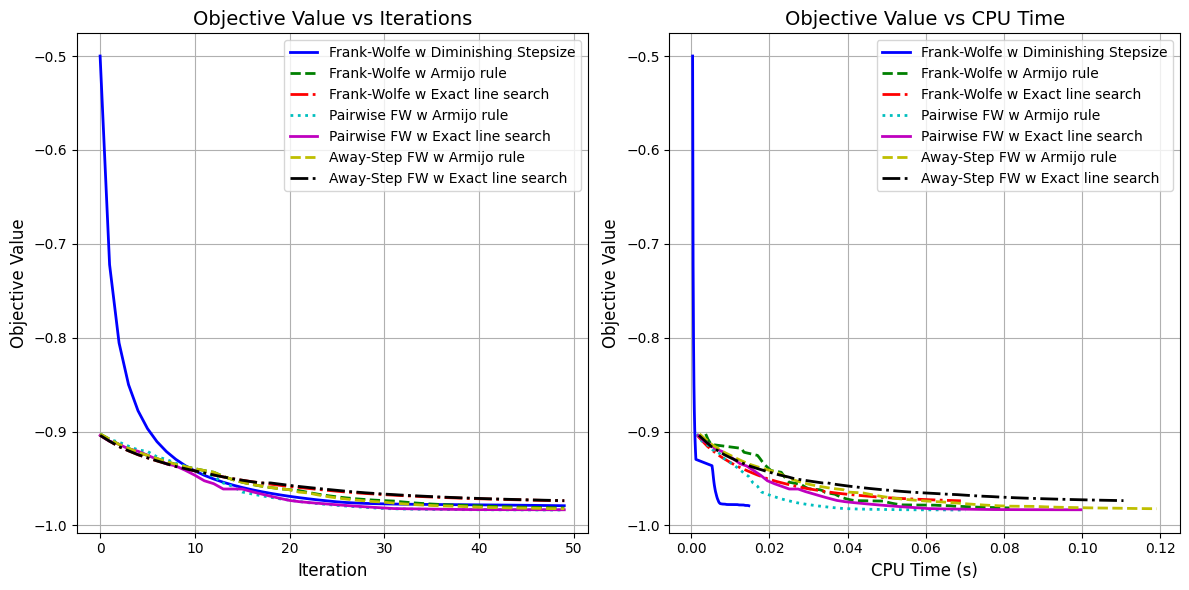

Graph: DSJC500_5
Best known result: 13
Frank-Wolfe w Diminishing Stepsize: Clique size = 10
Frank-Wolfe w Armijo rule: Clique size = 10
Frank-Wolfe w Exact line search: Clique size = 10
Pairwise FW w Armijo rule: Clique size = 10
Pairwise FW w Exact line search: Clique size = 9
Away-Step FW w Armijo rule: Clique size = 10
Away-Step FW w Exact line search: Clique size = 10


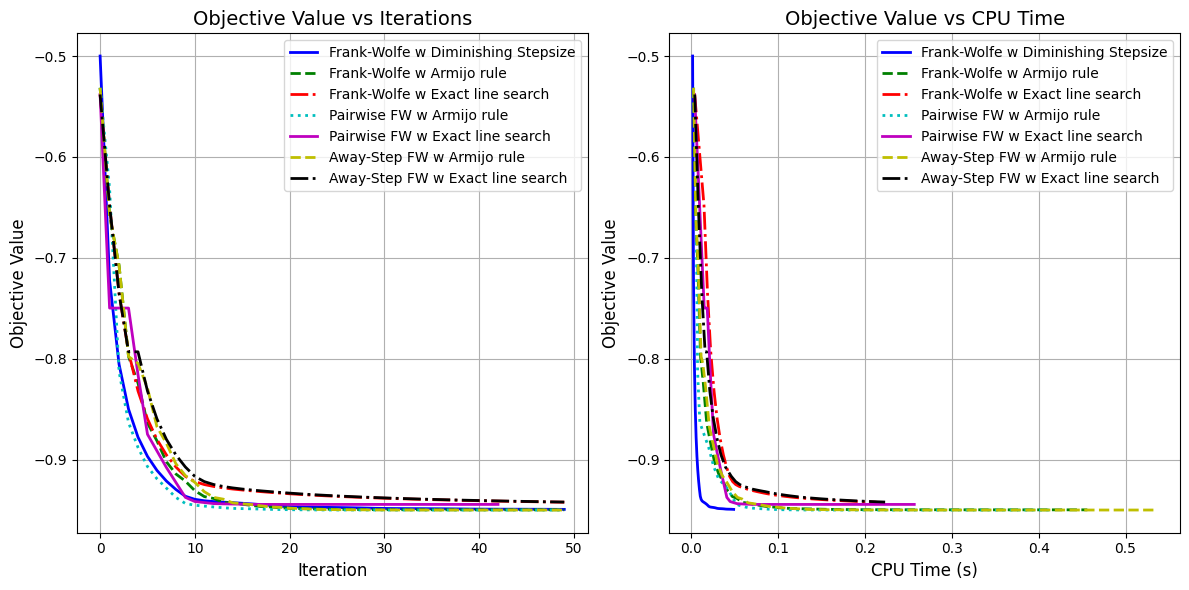

Graph: keller6
Best known result: 59
Frank-Wolfe w Diminishing Stepsize: Clique size = 31
Frank-Wolfe w Armijo rule: Clique size = 31
Frank-Wolfe w Exact line search: Clique size = 31
Pairwise FW w Armijo rule: Clique size = 33
Pairwise FW w Exact line search: Clique size = 33
Away-Step FW w Armijo rule: Clique size = 31
Away-Step FW w Exact line search: Clique size = 31


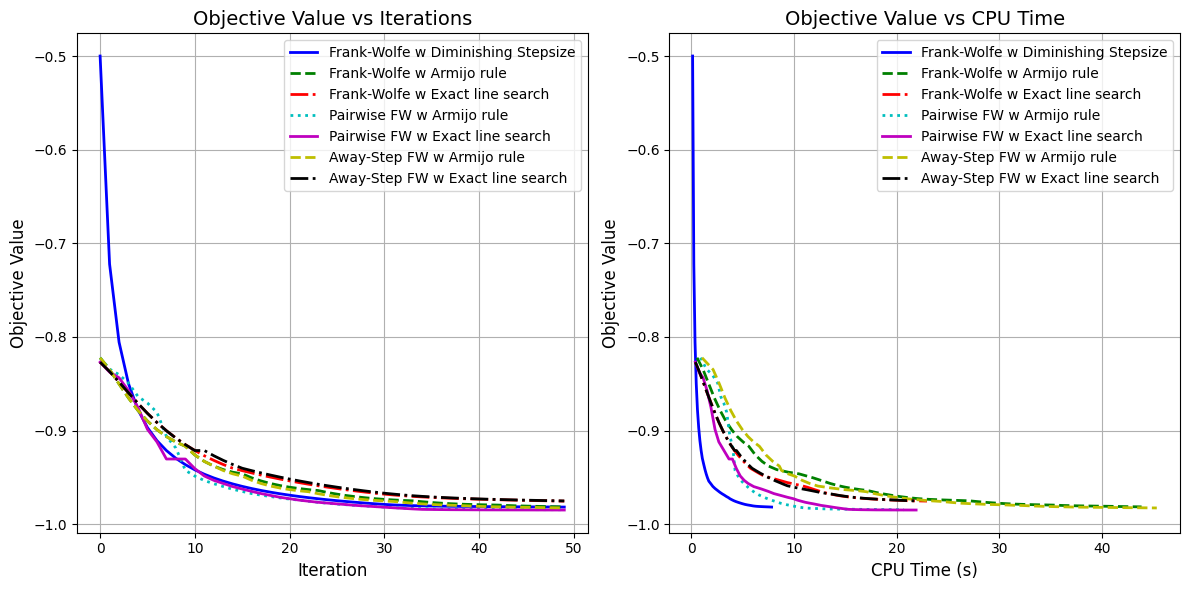

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# Function to run the experiment
def run_experiment(graph_file, max_iter=50, tol=1e-6, alpha=0.5):
    A = load_dimacs_graph(graph_file)
    n = A.shape[0]
    G = nx.from_numpy_array(A)
# degree based initialization
    degrees = np.sum(A, axis=0)
    x0 = degrees / np.sum(degrees)

# Run various Frank-Wolfe algorithms and collect results
    x_fw_d, conv_fw_d, time_fw_d = frank_wolfe_dimin(A, x0, max_iter, tol, alpha)
    x_fw_a, conv_fw_a, time_fw_a = frank_wolfe_armijo(A, x0, max_iter, tol, alpha)
    x_fw_ls, conv_fw_ls, time_fw_ls = frank_wolfe_els(A, x0, max_iter, tol, alpha)
    x_pfw_a, conv_pfw_a, time_pfw_a = pairwise_frank_wolfe_armijo(A, x0, max_iter, tol, alpha)
    x_pfw_ls, conv_pfw_ls, time_pfw_ls = pairwise_frank_wolfe_els(A, x0, max_iter, tol, alpha)
    x_asfw_a, conv_asfw_a, time_asfw_a = away_step_frank_wolfe_armijo(A, x0, max_iter, tol, alpha)
    x_asfw_ls, conv_asfw_ls, time_asfw_ls = away_step_frank_wolfe_els(A, x0, max_iter, tol, alpha)
    return (x_fw_d, conv_fw_d, time_fw_d), (x_fw_a, conv_fw_a, time_fw_a), (x_fw_ls, conv_fw_ls, time_fw_ls),(x_pfw_a, conv_pfw_a, time_pfw_a),(x_pfw_ls, conv_pfw_ls, time_pfw_ls), (x_asfw_a, conv_asfw_a, time_asfw_a), (x_asfw_ls, conv_asfw_ls, time_asfw_ls)

def analyze_results(results, graph_file, best_results):
    sizes = [np.sum(x > 1e-3) for x, _, _ in results]
    labels = ['Frank-Wolfe w Diminishing Stepsize', 'Frank-Wolfe w Armijo rule','Frank-Wolfe w Exact line search', 'Pairwise FW w Armijo rule', 'Pairwise FW w Exact line search','Away-Step FW w Armijo rule', 'Away-Step FW w Exact line search']
    convergences = [conv for _, conv, _ in results]
    times = [t for _, _, t in results]

    print(f"Graph: {graph_file}")
    print(f"Best known result: {best_results[graph_file]}")
    for label, size in zip(labels, sizes):
        print(f"{label}: Clique size = {size}")

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    linestyles = ['-', '--', '-.', ':', '-', '--', '-.']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    for label, convergence, time, color, linestyle in zip(labels, convergences, times, colors, linestyles):
        ax1.plot(convergence, label=label, color=color, linestyle=linestyle, linewidth=2)
        ax2.plot(time, convergence, label=label, color=color, linestyle=linestyle, linewidth=2)

    ax1.set_title("Objective Value vs Iterations", fontsize=14)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("Objective Value", fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True)

    ax2.set_title("Objective Value vs CPU Time", fontsize=14)
    ax2.set_xlabel("CPU Time (s)", fontsize=12)
    ax2.set_ylabel("Objective Value", fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Downloading datasets from URLs
datasets = {
    'C125.9': 'https://iridia.ulb.ac.be/~fmascia/files/DIMACS/C125.9.clq',
    'DSJC500_5': 'https://iridia.ulb.ac.be/~fmascia/files/DIMACS/DSJC500_5.clq',
    'keller6': 'https://iridia.ulb.ac.be/~fmascia/files/DIMACS/keller6.clq'
}

for name, url in datasets.items():
    download_and_save(url, f"{name}.clq")

# The best known maximum clique sizes for each graph
best_max = {
    'C125.9': 34,
    'DSJC500_5': 13,
    'keller6': 59
}
# Run experiments and analyze results
for dataset in datasets.keys():
    results = run_experiment(f"{dataset}.clq")
    analyze_results(results, dataset, best_max)
